Author: David Zhen Yin, yinzhen@stanford.edu; Lijing Wang, lijing52@stanford.edu; Jef Caers, jcaers@stanford.edu (2021)

This notebook provides an example executing direct sampling (DS) simulation in Python.


In [ ]:
# import necessary package
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tq
import os
%config InlineBackend.figure_format='retina'

In [ ]:
## Clone data from our GitHub repository
! git clone https://github.com/sdyinzhen/GS240_resources
## change directory to DS data folder
os.chdir('/content/GS240_resources/direct_sampling_py')

Cloning into 'GS240_resources'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 189 (delta 36), reused 61 (delta 19), pack-reused 111
Receiving objects: 100% (189/189), 154.03 MiB | 21.17 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Checking out files: 100% (37/37), done.


# Arctic dataset: gap-fill radar lines for high resolution topography.

Climate change can accelerate glacier melting and flow. Subglacial topography is a fundamental control on warm-water routing and glacier flow. However, topography is covered by thick ice sheet. Most subglacial elevations measured with sparse radar lines. Gap-filling the radar lines is therefore needed to obtain high resolution subglacial topography. 

Here, we have the radar line measurements of topography elevations from an Arctic area. 

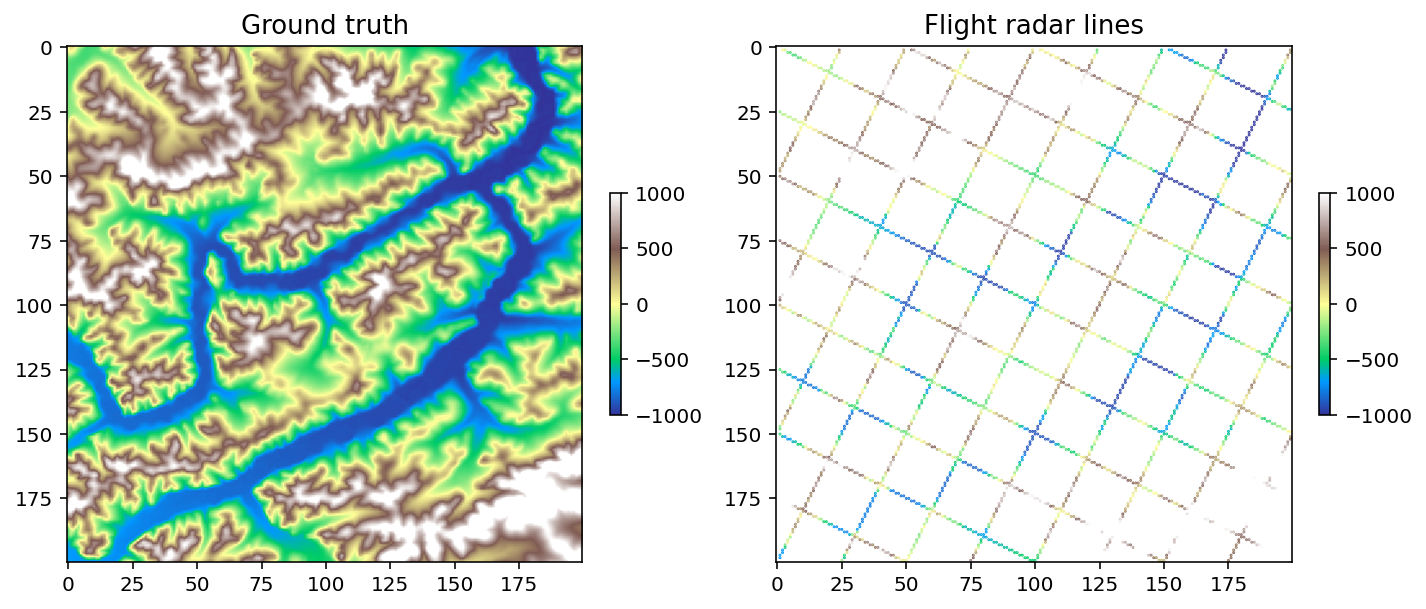

In [ ]:
# Load the ground truth of Arctic bed topography
Truth = np.loadtxt('Truth', skiprows=3).reshape(200,200)
# Load the radar lines of Arctic bed topography
Line_data = np.loadtxt('Line_data_v0', skiprows=3).reshape(200,200)

# plot the ground truth and radar line data
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(Truth, cmap='terrain', vmin=-1000, vmax=1000)
plt.colorbar(fraction=0.02)
plt.title('Ground truth', fontsize=13)
plt.subplot(122)
line_loc = np.argwhere(np.isfinite(Line_data))
plt.scatter(line_loc[:,1], line_loc[:,0], s=0.2, 
            c=Line_data[np.isfinite(Line_data)], cmap='terrain', vmin=-1000, vmax=1000)
plt.colorbar(fraction=0.02)
plt.imshow(Line_data)
plt.title('Flight radar lines', fontsize=13)
plt.tight_layout()

The right image shows the radar measurements of subglacial topography elevations in our study area. This area size is 100km x 100km.

The left image shows the ground truth of topography elevations 

Note in real applications, the ground truth is always unknown. We will only have radar lines. Here we give you the ground truth for illustration popurses.

Our goal is to build high resolution topography models by filling the line data. The built models should be as similar as possible to the truth. 

# What is direct sampling (DS)

Direct sampling is a versatile multiple-point statistics method for generating spatial-temporal geostatistical models. 
Using a training image as an explicit prior model, DS can generate realistic spatial models, honor hard and soft data, tackle multivariate, and quantify spatial uncertainty. 

In general, two key components within DS framework are: (1) extracting a conditioning pattern from the hard data (radar line here) simulation grid (SG) and (2) searching for a comparable pattern in the training image (TI). Note that “pattern” is also termed “data event” in MPS literature. 

A DS pixel-based simulation on an SG is illustrated in Figure below. In the neighborhood of a location to be simulated, the closest N informed locations are gathered. DS applies a user-defined radius r to define the neighborhood. Next, a comparable pattern is searched within the TI. Comparable here means, a pattern whose difference, as measured by a user-defined distance, is less than a certain stated tolerance. In DS, the search is random. Then, the distance between the conditioning pattern and the training image pattern is calculated. The distance being employed in the original DS is the Hamming distance for categorical variable, and the Euclidean distance for continuous variable, although any other distance can be used. Finally, DS retains the first comparable pattern. The central value of that comparable pattern is pasted into the SG.

<img src='https://drive.google.com/uc?export=view&id=11GeQXtePlEpIpmt45QvGQU4ysuYSOn-s' width = 70%/>

See literature review part of direct sampling in Zuo et al (2020). 
[Zuo, C., Yin, Z., Pan, Z., MacKie, E. J., & Caers, J. (2020). A Tree‐Based Direct Sampling Method for Stochastic Surface and Subsurface Hydrological Modeling. Water Resources Research, 56(2)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2019WR026130)

The DS code used in this notebook is also based on the above paper

To access the fast tree-based direct sampling code, go to
https://github.com/SCRFpublic/Tree-based_Direct_Sampling

# Ideal scenario: DS with ground truth as training image

We now use direct sampling to fill the gaps between radar lines. 

In [ ]:
# Load DSsim main function
from DSsim_point_based import *

Consider that we are in an ideal world. It means we have the ground truth. And we use it as the training image (TI).

Run **'DSsim_point_based'** direct sampling simulation package (2D).

Parameters settings in **'DSsim_point_based'** package:
- SimulationGrid: grid for DS simulation with hard data, 2D array 
- TI: training image, 2D array

Optional parameters:
-   DS_Neighbors: maximum hard data points in data pattern.
-   DS_PatternRadius: radius of the hard data pattern to compare to TI.
-   DS_DistanceThreshold_factor: distance tolerance threshold, 
        0: lowest, perfect match; 1: highest, randomly assign; recommend <0.05. 
        Threshold distance is computed as DS_DistanceThreshold_factor*(max(SimulationGrid) - min(SimulationGrid))
- DS_Fraction: fractions of TI to search for compatible patterns. The searching path is randomized.

NB: 
* This DSsim below is set as exhaustive searching with low tolerance to get the finest results. Therefore it will take long ~2hr. 
* To run DS fast, use the light version settings in the following realistic scenaro section. 

In [ ]:
# DSsim_data_grid: to make sure DS simulation is on the gridded radar line data. No data lociations are valued as as np.nan.
DSsim_data_grid= np.copy(Line_data)
# Run DS with ground truth as TI.
DS_realization_T = DSsim_point_based(SimulationGrid=DSsim_data_grid, 
                                     TI=Truth,
                                     DS_Neighbors = 30,
                                     DS_DistanceThreshold_factor=0.02,
                                     TI_SearchFraction=0.25
                                     )

To save your runing time, you can directly load the simulated results. 

Plot the DS simulation results

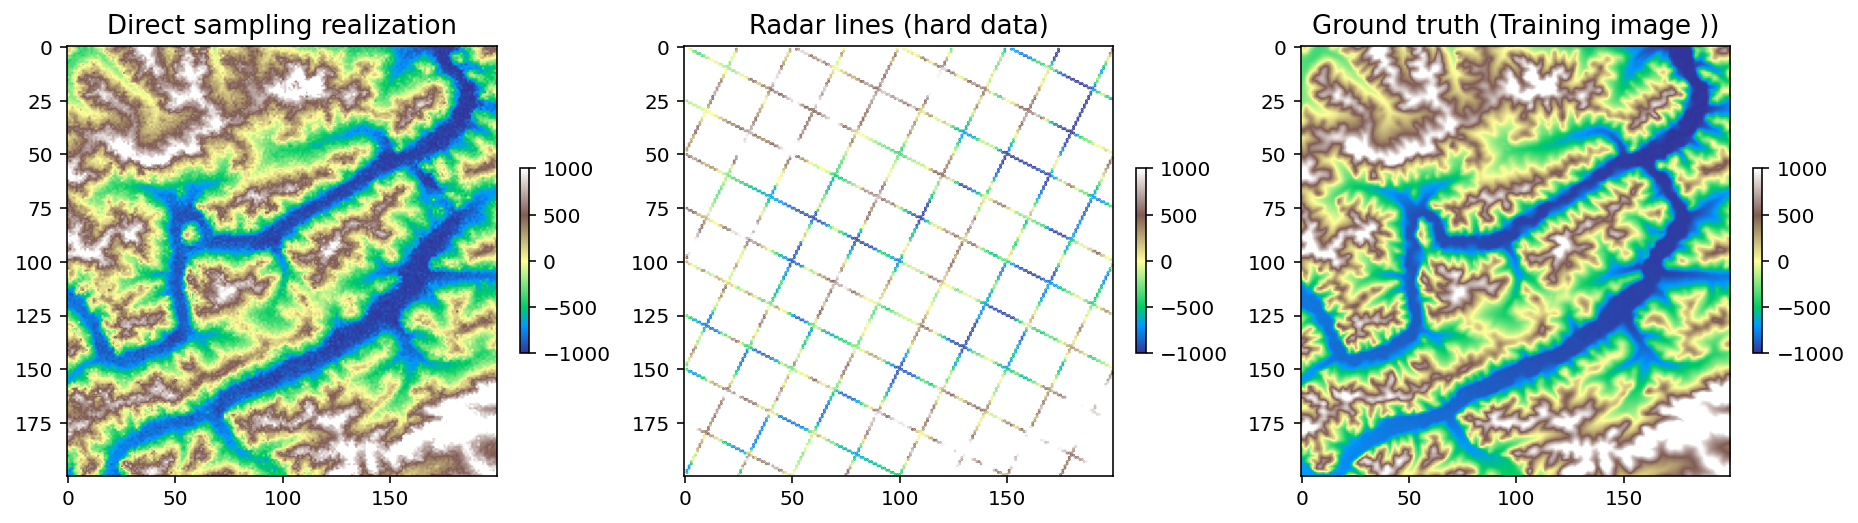

In [ ]:
DS_realization_T = np.load('result1_thr03_radius20.npy')
plt.figure(figsize=(13,5))
plt.subplot(131)
plt.imshow(DS_realization_T, cmap='terrain', vmin=-1000, vmax=1000)
plt.colorbar(fraction=0.02)
plt.title('Direct sampling realization', fontsize=13)
plt.subplot(132)
plt.scatter(line_loc[:,1], line_loc[:,0], s=0.2, 
            c=Line_data[np.isfinite(Line_data)], cmap='terrain', vmin=-1000, vmax=1000)
plt.colorbar(fraction=0.02)
plt.imshow(Line_data)
plt.title('Radar lines (hard data)', fontsize=13)
plt.subplot(133)
plt.imshow(Truth, cmap='terrain', vmin=-1000, vmax=1000)
plt.colorbar(fraction=0.02)
plt.title('Ground truth (Training image ))', fontsize=13)
plt.tight_layout()

Practically, we can accelerate DS simulation by setting higher distance tolerance between TI and hard data patterns, and searching (randomly) only part of the TI. This will save the runing time, but lower the result quality. 

To generate multiple realizations, run fast DS by changing parameter setings

In [ ]:
# DSsim_data_grid: to make sure DS simulation is on the gridded radar line data.
DSsim_data_grid= np.copy(Line_data)
# Run DS to generate multiple realizations. 
# Here we generate 2 realizations: realizations_num = 2
realizations_num = 2
DS_realizations = []
for realnum in range(realizations_num):
    DS_realization = DSsim_point_based(SimulationGrid=DSsim_data_grid, 
                                      TI=Truth, 
                                      DS_Neighbors = 30,
                                      TI_SearchFraction = 0.02,
                                      DS_DistanceThreshold_factor=0.05)
    DS_realizations.append(DS_realization)  

Plot results

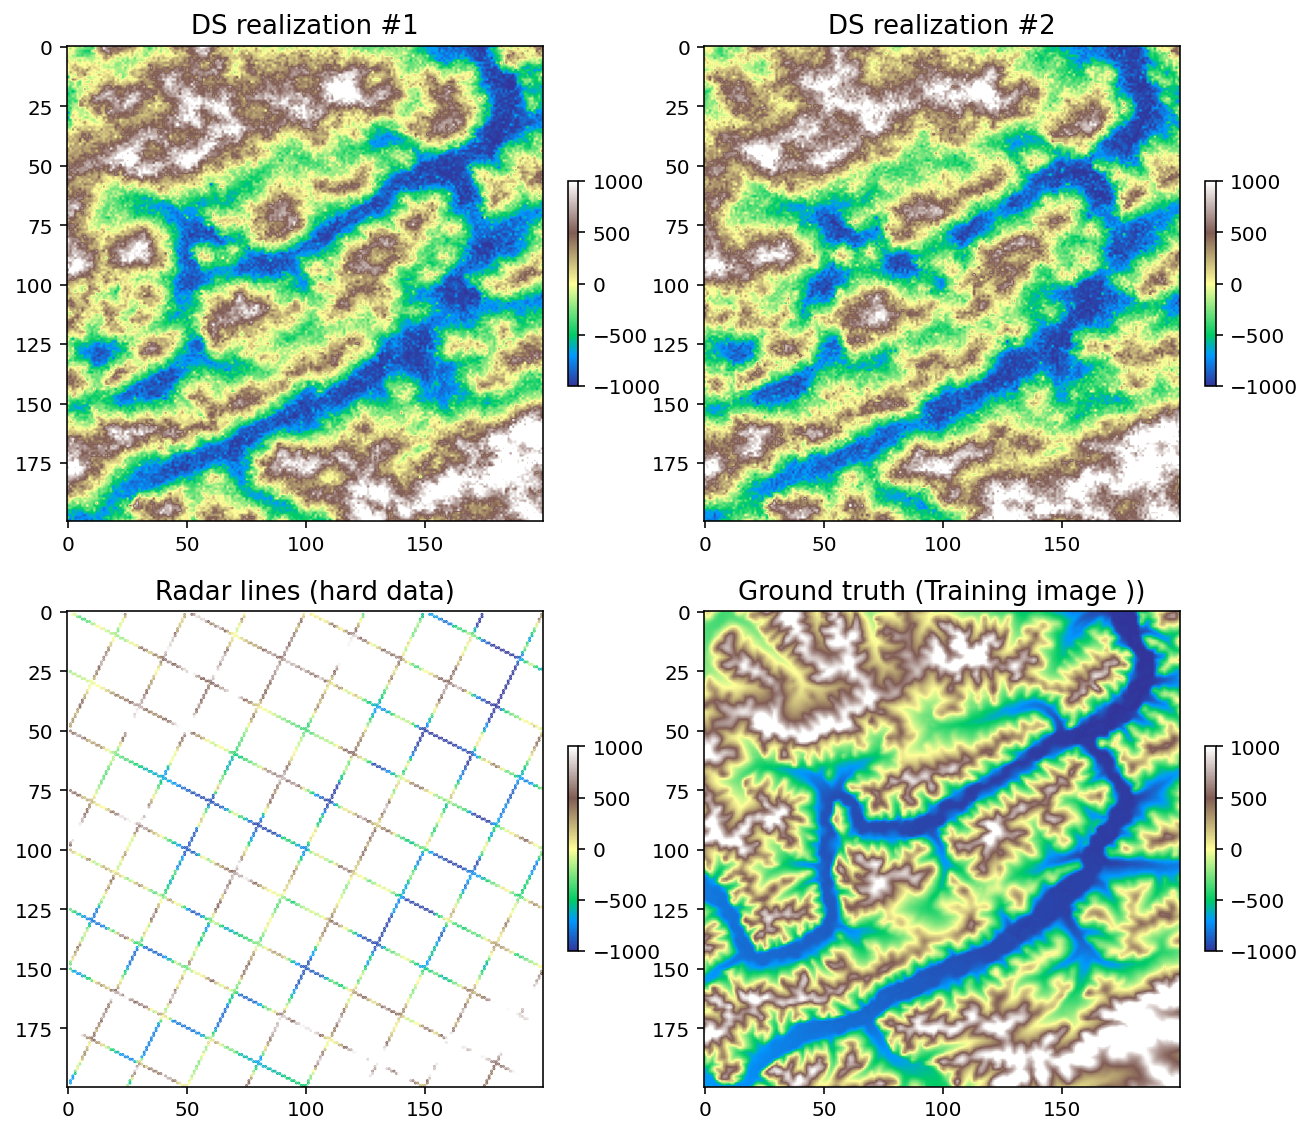

In [ ]:
plt.figure(figsize=(9,8))
for i in range(realizations_num):
  plt.subplot(2,2,i+1)
  plt.imshow(DS_realizations[i], cmap='terrain', vmin=-1000, vmax=1000)
  plt.colorbar(fraction=0.02)
  plt.title('DS realization #'+str(i+1), fontsize=13)
plt.subplot(223)
plt.scatter(line_loc[:,1], line_loc[:,0], s=0.2, 
            c=Line_data[np.isfinite(Line_data)], cmap='terrain', vmin=-1000, vmax=1000)
plt.colorbar(fraction=0.02)
plt.imshow(Line_data)
plt.title('Radar lines (hard data)', fontsize=13)
plt.subplot(224)
plt.imshow(Truth, cmap='terrain', vmin=-1000, vmax=1000)
plt.colorbar(fraction=0.02)
plt.title('Ground truth (Training image ))', fontsize=13)
plt.tight_layout()

Compare the DS simulation results to Sequential Gaussian simulation (in same colorbar). 



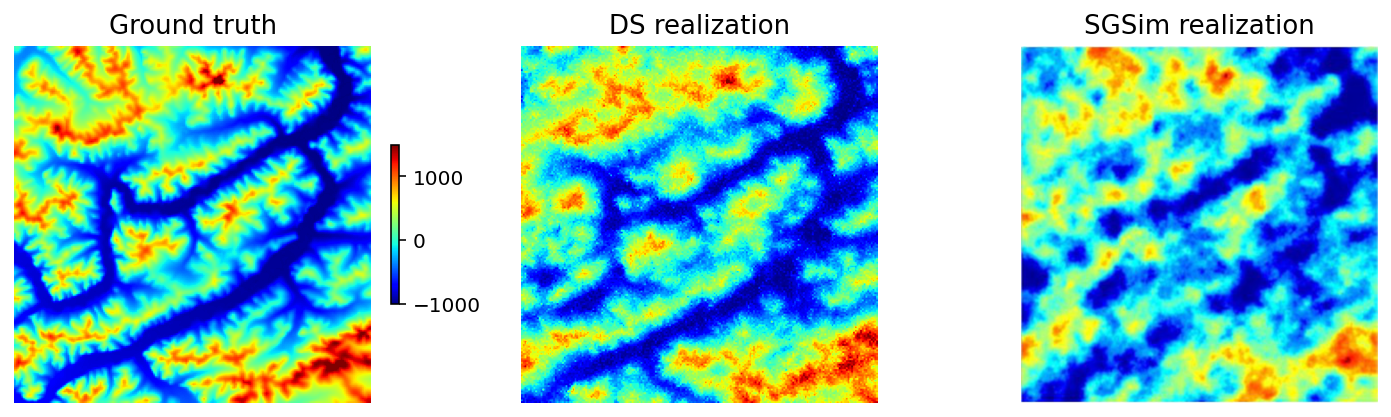

In [ ]:
DS_realization = np.load('DS_realization_T.npy')
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(Truth, cmap='jet', vmin=-1000, vmax=1500)
plt.colorbar(fraction=0.02)
plt.axis('off')
plt.title('Ground truth', fontsize=13)
plt.subplot(132)
plt.imshow(DS_realization, cmap='jet', vmin=-1000, vmax=1500)
plt.title('DS realization', fontsize=13)
plt.axis('off')
plt.subplot(133)
from PIL import Image
img = Image.open('DS_example2.jpg')
plt.imshow(img.resize((600,600)))
plt.title('SGSim realization', fontsize=13)
plt.axis('off')
plt.tight_layout()


# Realistic scenario: 3 training images

In real world, we don't have the ground truth image as TI. 

However, there are topography images from areas where ice sheets are melted. Some of them usually share similar topographical features to our study area. They can be used as training images to fill our radar line gaps. 

Below, we collect 3 Artic togography images nearby our study area. 

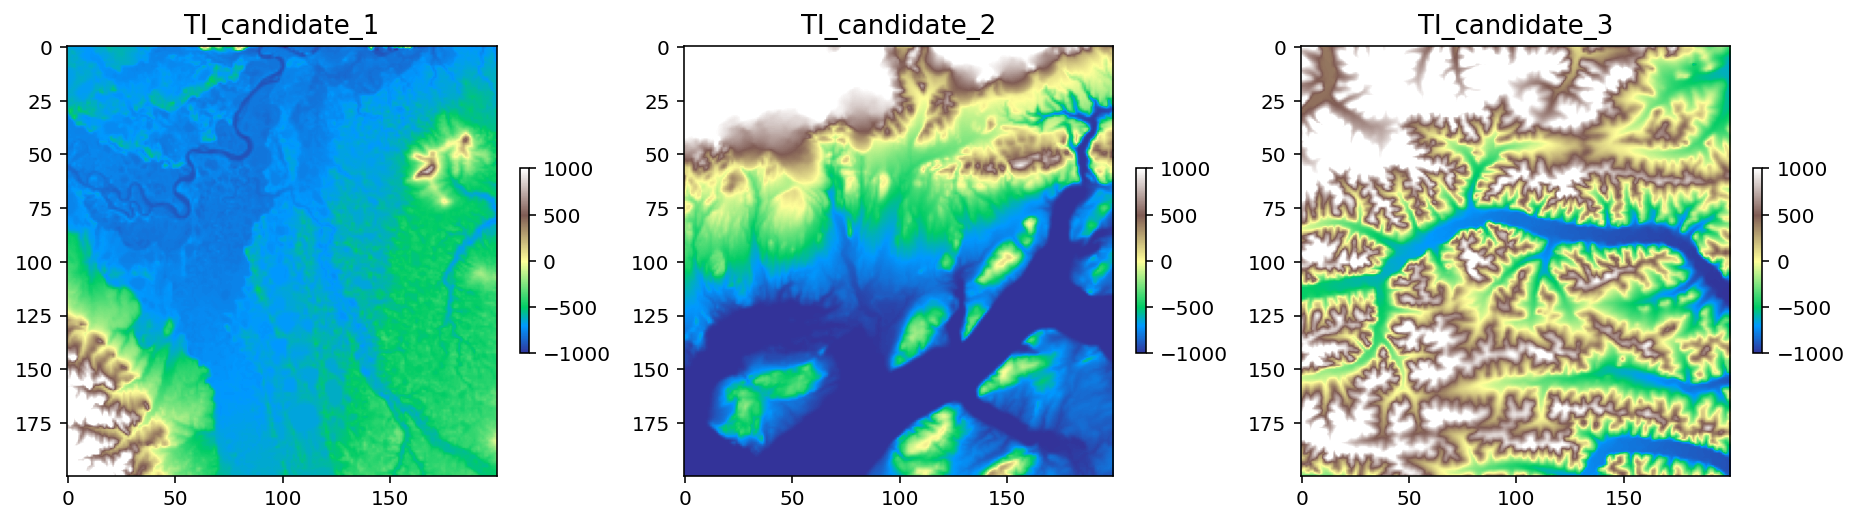

In [ ]:
TI_candidate_1 = np.loadtxt('TI_R1', skiprows=3).reshape(200,200)
TI_candidate_2 = np.loadtxt('TI_R2', skiprows=3).reshape(200,200)
TI_candidate_3 = np.loadtxt('TI_R3', skiprows=3).reshape(200,200)
plt.figure(figsize=(13,4))
plt.subplot(131)
plt.imshow(TI_candidate_1, cmap='terrain', vmin=-1000, vmax=1000)
plt.colorbar(fraction=0.02)
plt.title('TI_candidate_1', fontsize=13)
plt.subplot(132)
plt.imshow(TI_candidate_2, cmap='terrain', vmin=-1000, vmax=1000)
plt.colorbar(fraction=0.02)
plt.title('TI_candidate_2', fontsize=13)
plt.subplot(133)
plt.imshow(TI_candidate_3, cmap='terrain', vmin=-1000, vmax=1000)
plt.colorbar(fraction=0.02)
plt.title('TI_candidate_3', fontsize=13)
plt.tight_layout()

Which one should we take as training image in DS to fill the above radar lines? 

## Choose TI based on variograms

We can choose the best suitable TI based on variograms. 

Below we make the variograms of the above radar line data and candidate images . 

We can observe that TI_candidate_3 has the most similar variograms to the radar line data. This means they tend to share similar spatial correlations and variations. The other two images have clear trends that the radar data do not have. 

We therefore choose TI_candidate_3 as the TI

<img src='https://drive.google.com/uc?export=view&id=1R5oEsyqkh2lZE8CyooHwaxpIRhN1Xsqg' width = 70%/>

## Run direct sampling using selected TI

Run DS using TI_candidate_3 as training image. Use the above line data as hard data. 

In [ ]:
# ~ 6min
DSsim_grid= np.copy(Line_data)
DSsim_realization = DSsim_point_based(SimulationGrid=DSsim_grid, 
                                      TI=TI_candidate_3,
                                      DS_Neighbors = 30,
                                      TI_SearchFraction=0.02,
                                      DS_DistanceThreshold_factor=0.05)

100%|██████████| 40000/40000 [06:35<00:00, 101.06it/s]


Plot result

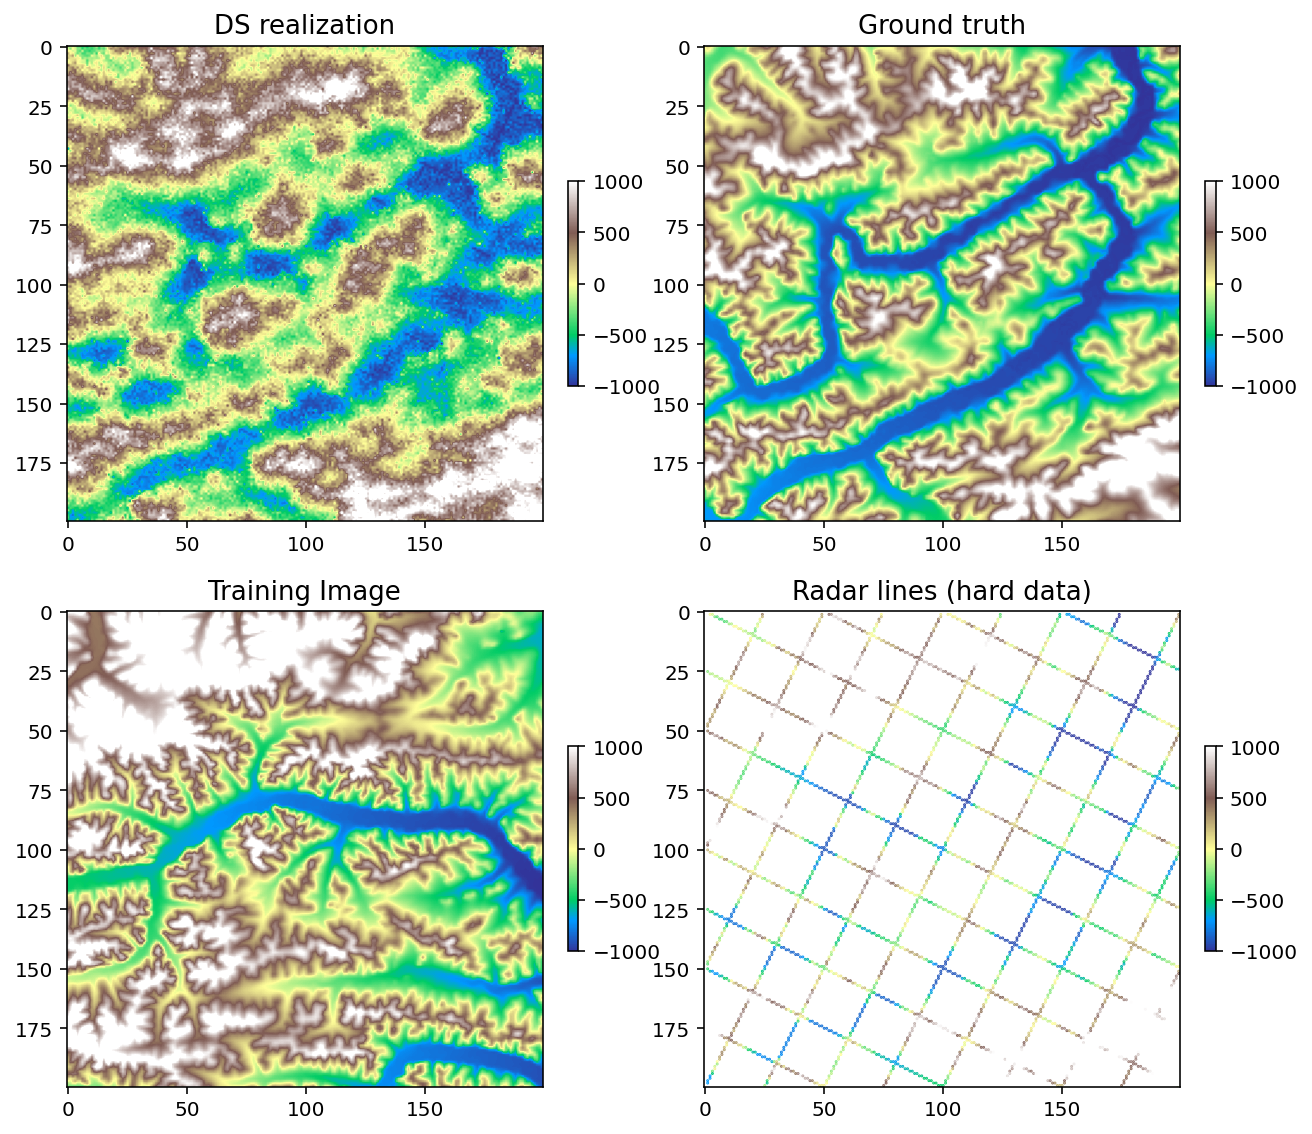

In [ ]:
plt.figure(figsize=(9,8))
plt.subplot(221)
plt.imshow(DSsim_realization, cmap='terrain', vmin=-1000, vmax=1000)
plt.colorbar(fraction=0.02)
plt.title('DS realization', fontsize=13)
plt.subplot(222)
plt.imshow(Truth, cmap='terrain', vmin=-1000, vmax=1000)
plt.colorbar(fraction=0.02)
plt.title('Ground truth', fontsize=13)
plt.subplot(223)
plt.imshow(TI_candidate_3, cmap='terrain', vmin=-1000, vmax=1000)
plt.colorbar(fraction=0.02)
plt.title('Training Image', fontsize=13)
plt.subplot(224)
plt.scatter(line_loc[:,1], line_loc[:,0], s=0.2, 
            c=Line_data[np.isfinite(Line_data)], cmap='terrain', vmin=-1000, vmax=1000)
plt.colorbar(fraction=0.02)
plt.imshow(Line_data)
plt.title('Radar lines (hard data)', fontsize=13)
plt.tight_layout()

## Quality control

Plot histogram beween DS result and radar data

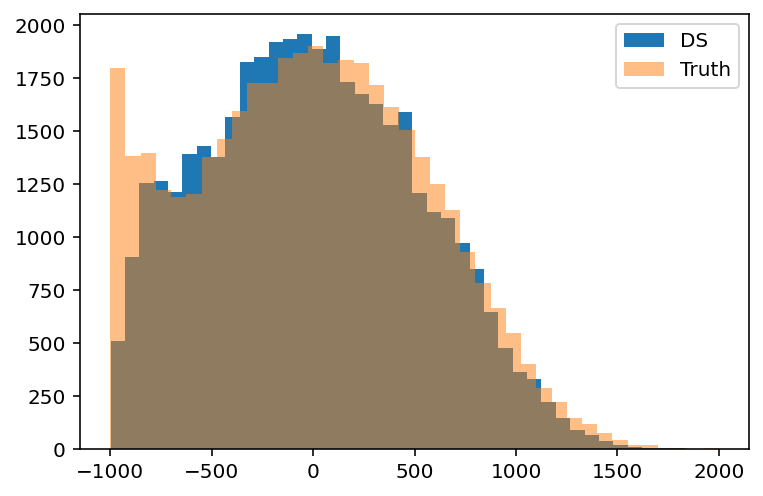

In [ ]:
plt.hist(DSsim_realization.flatten(), bins=40, label='DS')
plt.hist(Truth.flatten(), bins=40, label='Truth', alpha=0.5)
plt.legend()

QQ plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


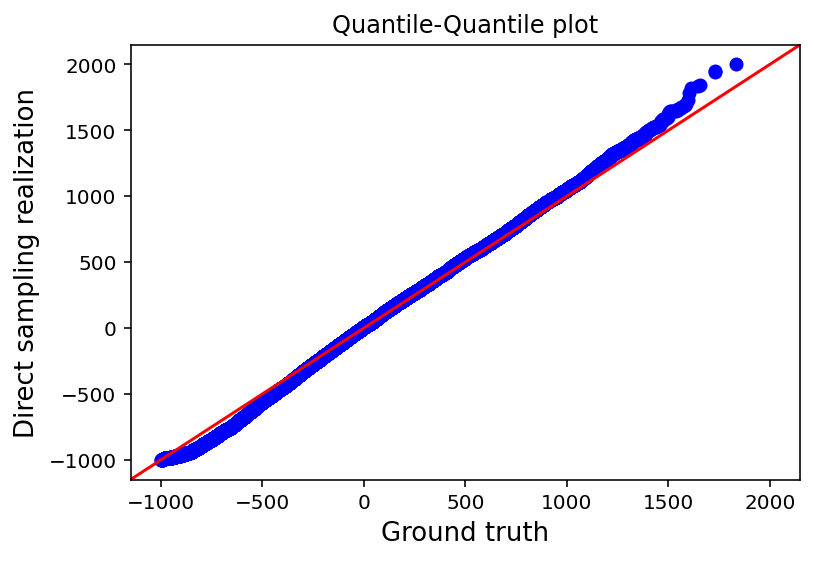

In [ ]:
from statsmodels.graphics.gofplots import qqplot_2samples
qqplot_2samples(Truth.flatten(),DSsim_realization.flatten(),line='45')
plt.xlabel('Ground truth',fontsize=13)
plt.ylabel('Direct sampling realization', fontsize=13)
plt.title('Quantile-Quantile plot')
plt.show()

Compare variograms: You can also the DS simulated realization to SGeMS. Generate variograms to see if they are the same as the line data and ground truth.